# Assignment 3
**CS283 Computer Vision, Harvard University, Fall 2023**

**Due Wednesday, Sep. 27, at 11:59pm**

Name: *(<font color=red>Alexia Hartogensis</font>)*

---

This problem set reinforces your understanding of camera matrices and binocular geometry. As usual, the assignment will be submitted electronically and formatted according to the guidelines. Notice the usual **Hints and Information** section at the bottom.

If you have not already done so, begin by creating a copy of this notebook in your google drive at filepath `My Drive/cs-283-assignments/A3/pset3.ipynb`. Then edit the notebook and submit it according to the instructions on the course website.

NOTE: Question 3 involves images of a 3D calibration target that was crudely constructed from a box and printed cherkerboards, and the 3D point coordinates that are provided as input are imperfect. When you plot the input 3D point cloud, you may notice that the box looks slightly skewed and that the checkerboard blocks are not perfectly square. Don't be alarmed. This is a problem with the data, not your code.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# YOU SHOULD HAVE ALREADY COPIED OVER THE ASSIGNMENT FILES TO A FOLDER
# TITLED "cs-283-assignments/A3" ON YOUR GOOGLE DRIVE
%cd "/content/drive/My Drive/cs-283-assignments/A3"


/content/drive/My Drive/cs-283-assignments/A3


In [ ]:
# Extract required pset folders
!curl -LJ0 https://github.com/Harvard-CS283/pset3/blob/main/pset3.tar.gz?raw=true | \
  tar -xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1451k  100 1451k    0     0   937k      0  0:00:01  0:00:01 --:--:--  937k


In [ ]:
# Import other required libraries here
import cv2           # OpenCV
import numpy as np   # numpy
import scipy.interpolate
import pickle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Use this line to make matplotlib plot notebook style (only need to call it once when importing matplotlib)
# %matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

## Question 1 (20%)
$\def\vO{{\bf O}}
\def\vP{{\bf P}}
\def\vp{{\bf p}}
\def\vx{{\bf x}}
\def\vt{{\bf t}}
\def\vl{{\bf l}}
\def\vm{{\bf m}}
\def\vX{{\bf X}}
\def\mS{{\bf S}}
\def\mT{{\bf T}}
\def\mH{{\bf H}}
\def\mA{{\bf A}}
\def\mM{{\bf M}}
\def\mP{{\bf P}}
\def\tx{{\tilde{\bf x}}}
\def\ta{{\tilde{\bf a}}}
\def\tb{{\tilde{\bf b}}}
\def\tc{{\tilde{\bf c}}}
\def\hn{{\bf \hat{n}}}
\def\hv{{\bf \hat{v}}}
\def\hh{{\bf \hat{h}}}
\def\vh{{\bf h}}
\def\vs{{\bf s}}
\def\hs{{\bf \hat{s}}}$

In class we saw that a camera matrix satisfies the equation $\vx_i=\mP\vX_i$, and HZ 7.1 shows that six 3D-2D matches $\vX\leftrightarrow\vx$ are sufficient to recover $\mP$ using a linear (non-iterative) algorithm.

**a.** Create and describe specialized linear algorithms for computing the camera matrix $\mP$ in the special cases when: i) the camera location (but not orientation) is known, and ii) the camera location and complete orientation are known.

### Answer:

The camera matrix P is a 3x4 matrix that solves $\vx_i=\mP\vX_i$ for all i. This problem is silmilar to solving for the 2D matrix H. We solve for P with corresponding points from the 3D points to the 2D points.

i. Let us define the matrix C as the camera location and also the center. Let us refigure the matrix P. Define each row separately.

\begin{equation}
P =
\begin{bmatrix}
    P^{1T} \\
    P^{2T} \\
    P^{3T}    
\end{bmatrix}
\end{equation}

From the textbook on page 160, we know that when we mulitply each row of P by the center world coordinates of the camera, we get zero.  We follow the equation $C*P^{nT} = 0$

Also define matrix p as a 12x1 matrix where each element is a value of matrix P.And A is a 3x12 matrix defined below.
\begin{equation}
\begin{bmatrix}
    C_x & C_y & C_z & 1 & 0 & 0^T \\
    0^T & C_x & C_y & C_z & 1 & 0^T \\
    0 & 0^T & C_x & C_y & C_z & 1
\end{bmatrix} * p = 0
\end{equation}

Using SVD, we can find the nullspace of matrix A by extracting the last column of the V vector. The nullspace will be a 12x1 vector so we can shape the vector into a 3x4 matrix and this will be our matrix P.

ii. From HZ we know that we can find the camera matrix with the camera center, rotation, and the calibration. $P = K[R | t]$ and  $t = −RC $ therefore $P= K[R | -RC]$. We know the rotation and the translation so we have C and R. We can solve for the augmented matrix $[R | -RC]$ or $R[I | -C]$ and then find the calibration matrix K. To find the calibration matrix, we can estimate the it by the equation $x_i \times KX_i$ or alternatively expressed as $x_i \times KX_i = 0$ Define $K^T = [k_1 k_2 k_3]$ and $x_i = [x_{i1} x_{i2} x_{i3}]$
\begin{equation}
  \begin{bmatrix}
      000 & x_{i3}X^T_i & -x_{i2}X^T_i \\
      x_{i2}X^T_i & -x_{i1}X^T_i & 000\\
  \end{bmatrix}
  \begin{bmatrix}
      k_1 \\
      k_2
  \end{bmatrix}
\end{equation} = 0

From here we can stack all the possible matches and cummulate a matrix A that will solve for the calibration matrix K. With the calibration matrix, we can solve for P with $P = KR[I | -C]$



**b.** Ignoring degenerate configurations, how many 2D-3D matches are required for there to be a unique solution in each case?  Justify your answers.

### Answer:

How many coresponding points do we need when we have the camera location and not the rotation matrix? First let us look at the matrix P a 3x4 matrix which needs 12 entries. And in class we discussed that a camera has 11 degrees of freedom. Thus, we would need to have 11 equations to solve for the matrix P. Since we have the camera location, and can find the camera origin in the projective coordinates. We only need 4 corresponding points.

Second, how many coresponding points do we need when we have both the camera location and rotation? Similarly to the part before, we have the camera location and therefore we have the corresponding points of the origin. However, the rotation can add an aspect of noise so we will need more than 4 corresponding points.

For a camera model with noise, there needs to be more than 6 point correspondences. This is due to the fact that the distortion introduces additional parameters. In this case we need to minimize algebraic or geometric error to figure out the number of correspondes needed. Some distortions we must consider are the barrel distortion, pincushion distortion, and the fisheye distortion. These distortions effect the calibration so we need more than 6 points to handle the new parameters.

### Disclosure of use of Generative AI for this question

<br />

I used AI to ask some clarifying questions. From the textbook, I could not figure out how to solve for the calibration matrix so I tried to see if ChatGPT would give me some advice on how to solve for it. And I asked for some help with laTex formatting.

<br />


## Question 2 (20%)

Let $I_0$ be an image of a scene captured by a first camera $P$, and let $I_1$ be another image captured by printing the first image $I_0$ and then snapping a picture of the flat print-out using a second camera (so that $I_1$ is "an image of an image"). Show that the second image $I_1$ can be equivalently explained as being captured directly from the original scene by some "apparent camera" $P'$, and that this apparent camera $P'$ has the same camera center as  $P$. Speculate on how this explains why a portrait's eyes "follow you around the room". Show, on the other hand, that all other parameters of the camera $P$ and the apparent camera $P'$ may be different.

_Hint:_ The null space of  an $n\times n$ invertible matrix $\mA$ is empty, i.e., $\mA\vx=0$ if and only if $\vx=0$.

### Answer:

For this problem we will be showing that the world coordinates of camera P and camera P' are different because of the different viewpoints, but the camera points are equal. Define $C$ to be the center of camera P and $C'$ the center of camera P'. With this information, we can write out the equations for the projection of the world points for cameras P and P' and convert them into camera pionts.


\begin{equation}
  \begin{bmatrix}
      fX + Zp_x \\
      fY + Zp_y \\
      Z \\
  \end{bmatrix}
  =
  \begin{bmatrix}
    f_x & 0 & p_x & 0 \\
    0 & f_y & p_y & 0 \\
    0 & 0 & 1 & 0
  \end{bmatrix}
  \begin{bmatrix}
     X \\
    Y \\
    Z \\
    1
  \end{bmatrix}
\end{equation}

\begin{equation}
  \begin{bmatrix}
      fX' + Z'p_x' \\
      f'Y' + Z'p_y' \\
      Z' \\
  \end{bmatrix}
  =
  \begin{bmatrix}
    f_x' & 0 & p_x' & 0 \\
    0 & f_y' & p_y' & 0 \\
    0 & 0 & 1 & 0
  \end{bmatrix}
  \begin{bmatrix}
     X' \\
    Y' \\
    Z' \\
    1
  \end{bmatrix}
\end{equation}

The first equation is for P and the second is for P'.

We need to find that even with different centers of the camera in the real world, both images have the same center of origin. To find the center of the camera location we can use the equation $\tilde{c} = -M^{-1}*p_4$. $p_4$ is the origin of the image camera in the projective plane. If we sent p_4 to equal general values, we can solve for the center of a camera.

\begin{equation}
  \begin{bmatrix}
      f & 0 & x_0 \\
      0 & f & y_0 \\
      0 & 0 & 1 \\
  \end{bmatrix}^{-1}
  =
  \begin{bmatrix}
    1 / f & 0 & -p_x/f \\
    0 & 1/f & -p_y/f \\
    0 & 0 & 1
  \end{bmatrix}
\end{equation}


\begin{equation}
  \tilde{c} =
  - \begin{bmatrix}
      1 / f & 0 & -p_x/f \\
      0 & 1/f & -p_y/f \\
      0 & 0 & 1
  \end{bmatrix}
  \begin{bmatrix}
      o_x \\
      o_y \\
      o_z
  \end{bmatrix}
  =
  \begin{bmatrix}
      -o_x/f + o_z*p_x/f \\
      -o_y/f + o_z*p_y/f \\
      -o_z
  \end{bmatrix}
\end{equation}

Now we have the camera's center in world coordinates, so we have protect the points to the image plane.

\begin{equation}
  \begin{bmatrix}
      fX + Zp_x \\
      fY + Zp_y \\
      Z \\
  \end{bmatrix}
  =
  \begin{bmatrix}
    f & 0 & p_x & 0 \\
    0 & f & p_y & 0 \\
    0 & 0 & 1 & 0
  \end{bmatrix}
  \begin{bmatrix}
      -o_x/f + o_z*p_x/f \\
      -o_y/f + o_z*p_y/f \\
      -o_z \\
      1
  \end{bmatrix}
\end{equation}

\begin{equation}
  \begin{bmatrix}
      fX + Zp_x \\
      fY + Zp_y \\
      Z \\
  \end{bmatrix}
  =
  \begin{bmatrix}
    -o_x + o_z * p_x - o_z*p_x \\
    -o_y + o_z * p_y - o_z*p_y\\
    -o_z
  \end{bmatrix}
\end{equation}

\begin{equation}
  \begin{bmatrix}
      fX + Zp_x \\
      fY + Zp_y \\
      Z \\
  \end{bmatrix}
  =
  \begin{bmatrix}
    -o_x\\
    -o_y\\
    -o_z
  \end{bmatrix}
\end{equation}

Now we can see that the principle point and the focal length do not affect the origin of the image coordinate system. Therefore, even though camera $C$ and $C'$ have different origins in real world coordinates, they have the same origin in image coordinates. This suggests that there are infinite ways to take the same image.

### Disclosure of use of Generative AI for this question

<br />

I used ChatGPT to help with laTex formatting and for claification on the problem.
<br />


## Question 3 (30%)

This assignment's data folder contains a stereo pair of images and a <tt>corners.pickle</tt> file containing some image-point coordinates and corresponding world-point coordinates. (See _Hints and Information_ below on how to load and use <tt>.pickle</tt> files.) In this question you will calibrate the two cameras in the stereo rig, and in the next question you will use this calibration information to reconstruct a 3D object. The input 2D and 3D points coordinates are visualized in the figure below.

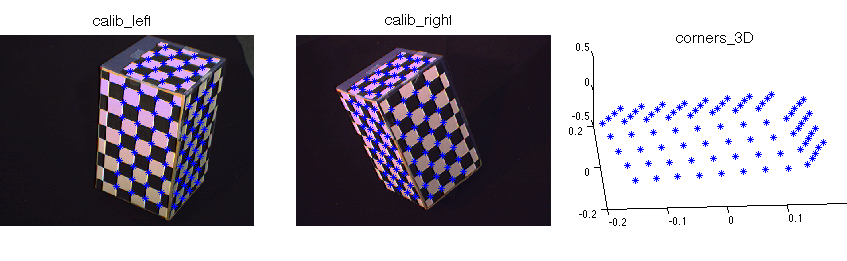

In [ ]:
from IPython.display import Image
Image('img/box.png')

**a.** Write a function <tt> getCamera(X3,X2)</tt> that computes a $3\times 4$ camera matrix <tt>P</tt> from an $n\times 3$ matrix of world coordinates <tt> X3</tt> and an $n\times 2$ matrix of pixel coordinates <tt>X2</tt> representing the projection of the world points into a single projective camera. Your function should use the "Linear Solution" with normalization/denormalization, as described in Algorithm 7.1 of HZ (the iterative refinement based on geometric error is not necessary).


In [ ]:
from numpy.lib.function_base import average
def getT(X1):
  c_x = np.average(X1[:, 0])
  c_y = np.average(X1[:, 1])

  average_dist = 0
  for x in X1:
    dist = np.sqrt(((x[0] - c_x) ** 2) + ((x[1] - c_y) ** 2))
    average_dist += dist

  average_dist /= (X1.size /2)
  s = np.sqrt(2) / average_dist
  tx = -c_x * s
  ty = -c_y * s
  M = np.matrix([[s, 0, tx], [0, s, ty], [0, 0, 1]])

  return M

def getU(X1):
  c_x = np.average(X1[:, 0])
  c_y = np.average(X1[:, 1])
  c_z = np.average(X1[:, 2])

  average_dist = 0
  for x in X1:
    dist = np.sqrt(((x[0] - c_x) ** 2) + ((x[1] - c_y) ** 2) + ((x[2] - c_z) ** 2))
    average_dist += dist

  average_dist /= (X1.size /3)
  s = np.sqrt(3) / average_dist
  tx = -c_x * s
  ty = -c_y * s
  tz = -c_z * s
  M = np.matrix([[s, 0, 0, tx], [0, s, 0, ty], [0, 0, s , tz], [0, 0, 0, 1]])

  return M

In [ ]:
def getCamera(X3, X2):
    # Problem 3(a)
    # the function that computes the 3x4 camera matrix P from nx3
    # world coordinates X3 and an nx2 matrix of pixel coordinates X2
    # representing the projection of the world points into a single
    # projective camera

    T = getT(X2)
    Xn2 = T.dot(np.concatenate([X2.transpose(), np.ones((1, len(X2[:,0])), dtype=np.float32)], axis=0)).transpose()

    U = getU(X3)
    Xn3 = U.dot(np.concatenate([X3.transpose(), np.ones((1, len(X3[:,0])), dtype=np.float32)], axis=0)).transpose()


    N = X3.shape[0]
    A = np.zeros((2*N, 12))
    for i in range(X3.shape[0]):
      x3,y3,z3,w3 = Xn3[i, 0], Xn3[i, 1] ,Xn3[i, 2], Xn3[i,3]
      x2, y2, z2 = Xn2[i, 0], Xn2[i, 1], Xn2[i, 2]

      A[2*i, :] = [0, 0, 0, 0,-z2*x3, -z2*y3, -z2*z3, -z2*w3, y2*x3, y2*y3, y2*z3, y2*w3]
      A[2*i +1, :] = [z2*x3, z2*y3, z2*z3, z2*w3, 0,0,0, 0, -x2*x3, -x2*y3, -x2*z3, -x2*w3]

    _,_,V = np.linalg.svd(A)

    P_tilda = V[-1,:].reshape(3,4)

    P = np.dot(np.dot(np.linalg.inv(T), P_tilda), U)

    return P

**b.** The file <tt> corners.pickle</tt> contains two $n\times 2$ matrices <tt>leftpts</tt> and <tt>rightpts</tt> storing the pixel coordinates of the checkered box corners observed in the images <tt>calib\_left.bmp</tt> and <tt>calib\_right.bmp</tt>. It also contains an $n\times 3$ matrix <tt>corners\_3D</tt> storing the world coordinates of the very same box corners.

1) Create two side by side images of the right points overlayed on <tt>calib\_right.bmp</tt> and the left points overlayed on <tt>calib\_left.bmp</tt>.

2) Using your function from part (a) estimate camera matrices <tt>Pl</tt> and <tt>Pr</tt> for the left and right cameras in this stereo pair.

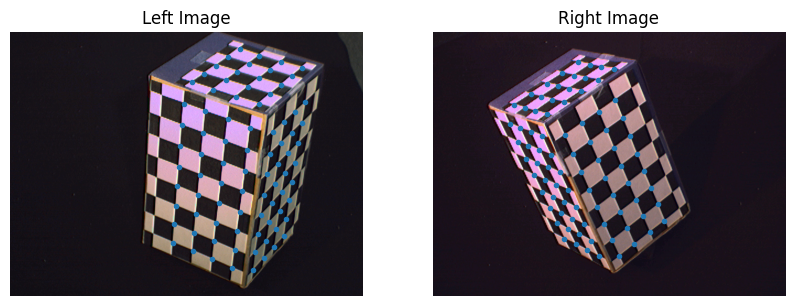

In [ ]:
# Import pickle file and extract matrices
import pickle
data = pickle.load(open('./data/corners.pickle', 'rb'))

leftpts = data['leftpts']
rightpts = data['rightpts']
corners_3D = data['corners_3D']


calib_right = np.float32(cv2.imread('./data/calib_right.bmp')) / 255.0
calib_right = cv2.cvtColor(calib_right, cv2.COLOR_BGR2RGB)

calib_left = np.float32(cv2.imread('./data/calib_left.bmp')) / 255.0
calib_left = cv2.cvtColor(calib_left, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(calib_left)
ax1.set_title('Left Image')
ax1.plot(leftpts[:, 0], leftpts[:, 1], '.')
ax1.axis('off')

ax2.imshow(calib_right)
ax2.set_title('Right Image')
ax2.plot(rightpts[:, 0], rightpts[:, 1], '.')
ax2.axis('off')

plt.show()

In [103]:
# Apply your getCamera function to estimate Pl and Pr below and print out the results:
Pl = getCamera(corners_3D, leftpts)
Pr = getCamera(corners_3D, rightpts)
np.set_printoptions(suppress=True)
print(Pl)
print(Pr)


[[  -9.04591856  366.62569771   42.1828723   239.66869606]
 [-611.90475436   -9.64555181   28.54664454  132.27252186]
 [  -0.09620083    0.05565793   -0.06980121    0.56170744]]
[[ 175.29208541 -292.06707945   76.80515167 -150.33679294]
 [ 522.82165591   88.07779904  -28.52702757 -133.07800346]
 [   0.0513271     0.05753448    0.0566242    -0.56298347]]


**c.** To display the results, create a 3D plot showing the 3D points in <tt>corners.pickle</tt> along with a depiction of the position, orientation, and field of view of your two cameras. Store your camera matrices as variables named <tt>Pl</tt> and <tt>Pr</tt> in a <tt>.pickle</tt> file named <tt>StereoCameras.pickle</tt> (for use in Question 4) and include this file in your zip. See Hints and Information below.

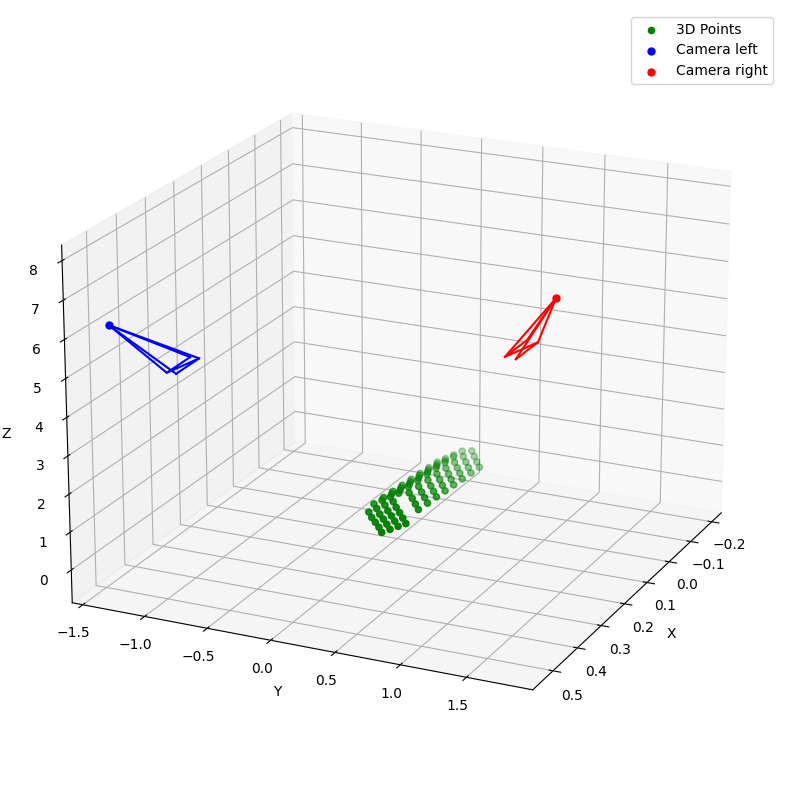

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

with open("./data/corners.pickle", "rb") as f:
    corners = pickle.load(f)

points_3d = corners['corners_3D']

camera_center_left = -np.linalg.inv(Pl[:, :3]).dot(Pl[:, 3])
camera_center_right = -np.linalg.inv(Pr[:, :3]).dot(Pr[:, 3])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='g', marker='o', label='3D Points')

cx_l, cy_l, cz_l = camera_center_left[0, 0], camera_center_left[1, 0], camera_center_left[2, 0]
ax.scatter(cx_l, cy_l, cz_l, c='b', marker='o', s=25, label='Camera left')

cx_r, cy_r, cz_r = camera_center_right[0, 0], camera_center_right[1, 0], camera_center_right[2, 0]
ax.scatter(cx_r, cy_r, cz_r, c='r', marker='o', s=25, label='Camera right')


min_x = min(points_3d[:,0])
max_x = max(points_3d[:,0])
min_y = min(points_3d[:,1])
max_y = max(points_3d[:,1])
min_z = min(points_3d[:,2])
max_z = max(points_3d[:,2])

corners = [[min_x, min_y, min_z], [max_x, min_y, min_z], [min_x, max_y, min_z], [max_x, max_y, min_z]]
endpoints_x = []
endpoints_y = []
endpoints_z = []
for i in corners:
  direction = i - camera_center_left.flatten()[0]
  direction = direction / np.linalg.norm(direction)
  endpoint = camera_center_left.flatten()[0] + 1.5 * direction
  line_x = [camera_center_left[0, 0], endpoint[0,0]]
  line_y = [camera_center_left[1, 0], endpoint[0,1]]
  line_z = [camera_center_left[2,0], endpoint[0,2]]
  ax.plot(line_x, line_y, line_z, c='b')
  endpoints_x.append(endpoint[0,0])
  endpoints_y.append(endpoint[0,1])
  endpoints_z.append(endpoint[0,2])

ax.plot(endpoints_x, endpoints_y, endpoints_z,c = 'b', linestyle='-')


endpoints_x = []
endpoints_y = []
endpoints_z = []
for i in corners:
  direction = i - camera_center_right.flatten()[0]
  direction = direction / np.linalg.norm(direction)
  endpoint = camera_center_right.flatten()[0] + 2 * direction
  line_x = [camera_center_right[0, 0], endpoint[0,0]]
  line_y = [camera_center_right[1, 0], endpoint[0,1]]
  line_z = [camera_center_right[2,0], endpoint[0,2]]
  ax.plot(line_x, line_y, line_z, c='r')
  endpoints_x.append(endpoint[0,0])
  endpoints_y.append(endpoint[0,1])
  endpoints_z.append(endpoint[0,2])

ax.plot(endpoints_x, endpoints_y, endpoints_z,c = 'r', linestyle='-')

azimuth_angle = 25
elevation_angle = 20

ax.view_init(elev=elevation_angle, azim=azimuth_angle)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

camera_mat = [Pl,Pr]
with open("./data/StereoCameras.pickle", "wb") as f:
    pickle.dump(camera_mat, f)
    f.close()

### Disclosure of use of Generative AI for this question

<br />

*OPTIONAL TO DO: Write your summary of Generative AI use here.*

<br />


## Question 4 (30%)

The images <tt>kleenex_left.bmp</tt> and <tt>kleenex_right.bmp</tt> comprise another
stereo pair captured by the same rig that was calibrated in Question 3. Here, you will use the calibration information obtained in that problem to reconstruct a 3D model of the Kleenex box.

**a.** When the two cameras in a stereo pair are calibrated and a left-right point match $\vx\leftrightarrow\vx'$ is given, the corresponding world point $\vX$ is recovered by back-projecting the rays through pixels $\vx$ and $\vx'$ and finding their point of intersection in 3-space.  This process is referred to as _triangulation_, and in the presence of noise, it can be solved using a linear algorithm.  The desired point $\vX$ must satisfy the equations $\vx=\mP\vX$ and $\vx'=\mP'\vX$, and these can equivalently be written as

$
\vx\times (\mP\vX)=0\ \ \mbox{and}\ \ \vx'\times (\mP'\vX)=0,
$

which are linear in the components of $\vX$.  Show that this system of equations can be written in the form $\mA\vX={\bf 0}$, with the elements of $\mA$ given explicitly in terms of $\vx$, $\vx'$, $\mP$ and $\mP'$.

### Answer:

First we can write out the equations, $\vx\times (\mP\vX)=0\ \ \mbox{and}\ \ \vx'\times (\mP'\vX)=0$ with arbitrary values for each matrix.

\begin{equation}
  \begin{bmatrix}
      x \\
      y \\
      z \\
  \end{bmatrix}
  \times
  \begin{bmatrix}
    p_{11} & p_{12} & p_{13} & p_{14} \\
    p_{21} & p_{22} & p_{23} & p_{24} \\
    p_{31} & p_{32} & p_{33} & p_{34}
  \end{bmatrix}
  \begin{bmatrix}
    X \\
    Y \\
    Z \\
    1
  \end{bmatrix}
  = 0
\end{equation}
The matrix would be the same for matrix $P'$. Next we can multiply out the values and take the cross product.

\begin{equation}
  \begin{bmatrix}
      x \\
      y \\
      z \\
  \end{bmatrix}
  \times
  \begin{bmatrix}
    p_{11}*X + p_{12}*Y + p_{13}*Z + p_{14} \\
    p_{21}* X + p_{22}*Y + p_{23}*Z + p_{24} \\
    p_{31}*X + p_{32}*Y + p_{33}*Z + p_{34}
  \end{bmatrix}
  = 0
\end{equation}

\begin{equation}
  \begin{bmatrix}
    y(p_{31}*X + p_{32}*Y + p_{33}*Z + p_{34}) - z(p_{21}* X + p_{22}*Y + p_{23}*Z + p_{24}) \\
    -x(p_{31}*X + p_{32}*Y + p_{33}*Z + p_{34}) + z(p_{11}*X + p_{12}*Y + p_{13}*Z + p_{14}) \\
    x(p_{21}* X + p_{22}*Y + p_{23}*Z + p_{24}) - y(p_{11}*X + p_{12}*Y + p_{13}*Z + p_{14})
  \end{bmatrix}
\end{equation}

\begin{equation}
  \begin{bmatrix}
    yp_{31} - zp_{21} & yp_{32} - zp_{22} & yp_{33} - zp_{23} & yp_{34} - zp_{24} \\
    -xp_{31} + zp_{11} & -xp_{32} + zp_{12} & -xp_{33} + zp_{13} & -xp_{34} + zp_{14} \\
    xp_{21} - yp_{11} & xp_{22} - yp_{12} & xp_{23} - yp_{13} & xp_{24} - yp_{14} \\
  \end{bmatrix}
  \begin{bmatrix}
      X \\
      Y \\
      Z \\
  \end{bmatrix}
\end{equation}

We can do the same for $P'$ and stack the answers on top of eachother to get a matrix A that is $6x4$.

**b.** Write a function <tt>triangulate(x1,x2,P1,P2) </tt> that takes camera matrices <tt> P1 </tt>, <tt> P2</tt> and image points <tt> x1</tt>, <tt> x2</tt> and estimates the 3D world point <tt> X</tt> by solving the homogeneous matrix equation developed in part (a). See the skeleton script.


In [94]:
def triangulate(x1, x2, P1, P2):
    # x1: points from left image
    # x2: points from right image
    # P1: left camera matrix
    # P2: right camera matrix

    P1 = P1.flatten()
    P2 = P2.flatten()

    x_1,y_1 = x1[0,0], x1[0,1]
    x_2, y_2 = x2[0,0], x2[0,1]

    z_1 = 1
    z_2 = 1

    A = [[y_1 * P1[0,8] - z_1 * P1[0,4], y_1 * P1[0,9] - z_1 * P1[0,5], y_1 * P1[0,10] - z_1 * P1[0,6], y_1 * P1[0,11] - z_1 * P1[0,7]],
        [-x_1 * P1[0,8] + z_1 * P1[0,0], -x_1 * P1[0,9] + z_1 * P1[0,1], -x_1 * P1[0,10] + z_1 * P1[0,2], -x_1 * P1[0,11] + z_1 * P1[0,3]],
        [x_1 * P1[0,4] - y_1 * P1[0,0], x_1 * P1[0,5] - y_1 * P1[0,1], x_1 * P1[0,6] - y_1 * P1[0,2], x_1 * P1[0,7] - y_1 * P1[0,3]],
        [y_2 * P2[0,8] - z_2 * P2[0,4], y_2 * P2[0,9] - z_2 * P2[0,5], y_2 * P2[0,10] - z_2 * P2[0,6], y_2 * P2[0,11] - z_2 * P2[0,7]],
        [-x_2 * P2[0,8] + z_2 * P2[0,0], -x_2 * P2[0,9] + z_2 * P2[0,1], -x_2 * P2[0,10] + z_2 * P2[0,2], -x_2 * P2[0,11] + z_2 * P2[0,3]],
        [x_2 * P2[0,4] - y_2 * P2[0,0], x_2 * P2[0,5] - y_2 * P2[0,1], x_2 * P2[0,6] - y_2 * P2[0,2], x_2 * P2[0,7] - y_2 * P2[0,3]]]

    _,_,V = np.linalg.svd(A)
    X = V[-1,:]

    return X

**c.** In this part, the file <tt>kleenex_corners.pickle</tt> provides the pixel coordinates of the seven visible corners of the Kleenex box from images <tt> kleenex\_left.bmp</tt> and <tt> kleenex\_right.bmp</tt>.

For each of these seven correspondences $\vx_i\leftrightarrow\vx_i'$, use your function from part (b) along with the camera matrices <tt> Pl</tt> and <tt> Pr</tt> that you stored in <tt> StereoCameras.pickle</tt> to find the world coordinates of the corresponding 3D points through triangulation.  Estimate the position of the eighth (unseen) corner by assuming symmetry in the box. Create a 3D plot of a wireframe of the box along with the same graphical camera representations used in 3.

In [95]:
# Load the corners pixel coordinates data
with open("./data/kleenex_corners.pickle", "rb") as f:
    kleenex_corners = pickle.load(f)

lpts = kleenex_corners[0] # kleenex_left.bmp corners coordinates
rpts = kleenex_corners[1] # kleenex_right.bmp corners coordinates

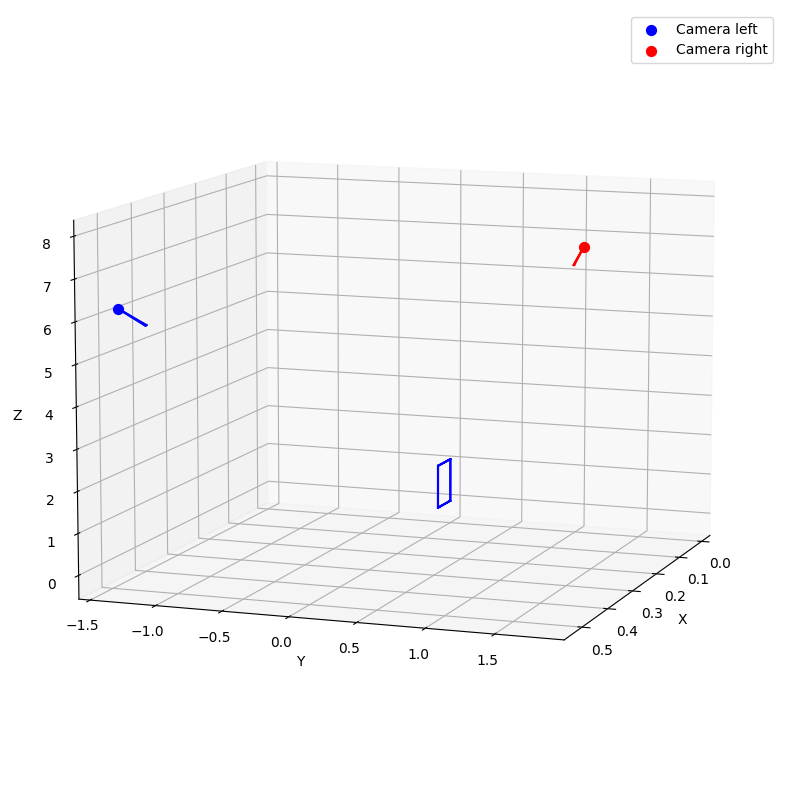

In [130]:
with open("./data/StereoCameras.pickle", "rb") as f:
    P_matrices = pickle.load(f)

Pl = P_matrices[0].reshape(3,4)
Pr = P_matrices[1].reshape(3,4)


X = triangulate(lpts, rpts, Pl, Pr)

width = np.linalg.norm(X[0] - X[1])
height = np.linalg.norm(X[1] - X[2])
length = np.linalg.norm(X[2] - X[3])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

vertices = [
    [0, 0, 0],
    [width, 0, 0],
    [width, height, 0],
    [0, height, 0],
    [0, 0, length],
    [width, 0, length],
    [width, height, length],
    [0, height, length]
]

edges = [
        [vertices[0], vertices[1], vertices[2], vertices[3], vertices[0]],
        [vertices[4], vertices[5], vertices[6], vertices[7], vertices[4]],
        [vertices[0], vertices[4]],
        [vertices[1], vertices[5]],
        [vertices[2], vertices[6]],
        [vertices[3], vertices[7]]]

for edge in edges:
  xs, ys, zs = zip(*edge)  # Unzip the vertices
  ax.plot(xs, ys, zs, c='b')


camera_center_left = -np.linalg.inv(Pl[:, :3]).dot(Pl[:, 3])
camera_center_right = -np.linalg.inv(Pr[:, :3]).dot(Pr[:, 3])

cx_l, cy_l, cz_l = camera_center_left[0], camera_center_left[1], camera_center_left[2]
ax.scatter(cx_l, cy_l, cz_l, c='b', marker='o', s=50, label='Camera left')

cx_r, cy_r, cz_r = camera_center_right[0], camera_center_right[1], camera_center_right[2]
ax.scatter(cx_r, cy_r, cz_r, c='r', marker='o', s=50, label='Camera right')


endpoints_x = []
endpoints_y = []
endpoints_z = []
for i in vertices[:3]:
  direction = i - camera_center_left.T
  direction = direction / np.linalg.norm(direction)
  endpoint = camera_center_left.T + 0.5 * direction
  line_x = [camera_center_left[0, 0], endpoint[0,0]]
  line_y = [camera_center_left[1, 0], endpoint[0,1]]
  line_z = [camera_center_left[2,0], endpoint[0,2]]
  ax.plot(line_x, line_y, line_z, c='b')
  endpoints_x.append(endpoint[0,0])
  endpoints_y.append(endpoint[0,1])
  endpoints_z.append(endpoint[0,2])


ax.plot(endpoints_x, endpoints_y, endpoints_z,c = 'b', linestyle='-')


endpoints_x = []
endpoints_y = []
endpoints_z = []
for i in vertices[:3]:
  direction = i - camera_center_right.T
  direction = direction / np.linalg.norm(direction)
  endpoint = camera_center_right.T + 0.5 * direction
  line_x = [camera_center_right[0, 0], endpoint[0,0]]
  line_y = [camera_center_right[1, 0], endpoint[0,1]]
  line_z = [camera_center_right[2,0], endpoint[0,2]]
  ax.plot(line_x, line_y, line_z, c='r')
  endpoints_x.append(endpoint[0,0])
  endpoints_y.append(endpoint[0,1])
  endpoints_z.append(endpoint[0,2])

ax.plot(endpoints_x, endpoints_y, endpoints_z,c = 'r', linestyle='-')

azimuth_angle = 20
elevation_angle = 10

ax.view_init(elev=elevation_angle, azim=azimuth_angle)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

**d.** Given that the dimensions of each square in the checker board pattern used for calibration are 2cm$\times$2cm, estimate the volume of the kleenex box.

In [127]:
x1 = leftpts[0]
y1 = leftpts[1]
dist_check = np.sqrt((x1[0] - y1[0]) ** 2 + (x1[1] - y1[1])**2)

min_x = min(lpts[:,0])
max_x = max(lpts[:,0])
min_y = min(lpts[:,1])
max_y = max(lpts[:,1])

width = max_x - min_x
height = max_y - min_y

width = (width / dist_check) * 2
height = (height / dist_check) * 2

volume = width * height
print(volume)

178.8889168693529


### Answer:
To find the volume of the box, we can multiply the height and width. But we do not know the length of the kleenex box. We do know the size of a square in the checkered box is 2x2 cm. Thus, we can calculate the ratio between the height and width of the kleenex box and the checkered box. Above is my code for how I calculted the height and width of the kleenex by finding the bounding box and then I calculated the ratio with the checkered box. The volume I got is: 178.8889168693529 $cm^3$

### Disclosure of use of Generative AI for this question

<br />

*OPTIONAL TO DO: Write your summary of Generative AI use here.*
I tried to use chatGPT to give me the cross product for question a but it did not give me the correct cross product so I resulted on doing it by myself. And I used chatGPT to graph the box in part c.
<br />


## Bonus Question 5 (10%)

> Indented block



Exploit the fact that the box is polygonal and symmetric to obtain a complete 3D model using the eight points recovered in Prob 4. The box consists of six planar facets $\Pi_k,\ k=1\ldots 6$, and for each facet, there are necessarily homographies between it (as a world plane) and each of the two image planes of the stereo rig.  By estimating these homographies, the texture for each (visible) facet can be extracted from the images and "mapped on" to a 3D model. Create a 3D model with texture taken from the images and mapped onto each facet. (Unobserved facets can be hallucinated by assuming symmetry.) The result can be displayed using repeated calls to the <tt> plot_surface </tt> command as described in the hints and and information.

In [ ]:
# Rectify the faces of the kleenex box

# TO DO: your code here

In [ ]:
# Overlay the images on your box:

# TO DO: your code here

### Disclosure of use of Generative AI for this question

<br />

*OPTIONAL TO DO: Write your summary of Generative AI use here.*

<br />


## Hints and Information

`.pickle` files are data containers used by Python. A `.pickle` file may include matrices, arrays, scalars or even functions. To save some variables in current workspace into a `.pickle`30/75 file, use the following
  command

```python
camera_mat = [Pl,Pr]
with open("./data/camera_matrices.pickle", "wb") as f:
    pickle.dump(camera_mat, f)
    f.close()
```

This will create a <tt> filename.pickle</tt> file in your current directory, which can be loaded later (say when you exit and reopen jupyterhub next time).The loading command is
  
```python
with open("./data/camera_matrices.pickle", "rb") as f:
    camera_matrices = pickle.load(f)
```

This will dump the variables you saved last time (<tt> var1, var2 </tt>, ...) into the current workspace.

A convenient graphical representation for a camera is a pentahedron.  One vertex of the five-sided polygon is placed at the camera center, and the other four vertices are found by back-projecting rays through the four corners of the image and placing a point along each ray at a fixed distance $d$ from the camera center. When these vertices are connected, the camera looks like a pyramid, and it's position, orientation, and field of view can all be readily observed.

Recovering the camera center and other useful information from a camera matrix is discussed in Sect. 6.2 of HZ. This is an important section to read. In python, a polygon can be drawn as a wireframe using the <tt> plot </tt> command or as a solid using the <tt> PolyCollection </tt> command.
    
In Python the <tt> plot_surface </tt> command can be used to draw a rectangular facet with an image texture-mapped onto it. This is done by setting the <tt>facecolors </tt> property of the surface to a color or grayscale image array. Consult the online documentation for matplotlib <tt> plot_surface </tt> for more information.

The following code loads an image and texture-maps it onto a rectangular facet with top-left corner $(0,1,0)$ and bottom-right corner $(1,0,0)$.

```python
kleenex_left = np.float32(cv2.imread('./data/kleenex_left.bmp')) / 255.0
kleenex_left = cv2.cvtColor(kleenex_left, cv2.COLOR_BGR2RGB)

x, y = np.meshgrid(np.linspace(0, 1, kleenex_left.shape[1]+1), np.linspace(0, 1, kleenex_left.shape[0]+1))


face = np.array([[0,1,0],
                 [1,1,0],
                 [0,0,0],
                 [1,0,0]])
points = [face[0, i] * (1-x) * (1-y) + face[1, i] * x * (1 - y) +
          face[2, i] * (1-x) * y +     face[3, i] * x * y for i in range(3)]

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(*points, rstride=5, cstride=5, facecolors=kleenex_left)
```

# Submission

The cells below generate two files in the folder `cs-283-assignments/A3/submit` on your Google Drive:

1.   `LASTNAME_FIRSTNAME_pset3.html`: an HTML report of your notebook **[Submit to Gradescope, after converting to PDF format]**
2.   `LASTNAME_FIRSTNAME_pset3.zip`: a `.zip` file including (1) all of the source files in the folder `pset3`, and (2) `pset3.ipynb` **[Submit to Canvas]**

**Remember to edit the filenames (either in the cells below or on your local computer after downloading) to match your name, and make sure to save your notebook before running the cells.**


In [ ]:
!mkdir "submit"

In [ ]:
# Convert to HTML - don't forget to add your name
# Make sure to save your notebook before running the following
!jupyter nbconvert --to html pset3.ipynb --output-dir "submit" --output "LASTNAME_Alexia_pset3.html"

In [ ]:
from zipfile import ZipFile
import os

def write_folder(zip, path):
    for dirpath, dirs, files in os.walk(path):
        for f in files:
            fn = os.path.join(dirpath, f)
            zip.write(fn)

def write_file(zip, path):
    zip.write(path)

In [ ]:
# Zip source - don't forget to add your name
with ZipFile('submit/LASTNAME_FIRSTNAME_pset3.zip', 'w') as zip_obj:
    write_folder(zip_obj, "pset3")
    write_file(zip_obj, "pset3.ipynb")